In [1]:
import keras
from keras import layers
from keras import ops
from keras.utils import load_img
from keras.utils import array_to_img
from keras.utils import img_to_array
from keras.preprocessing import image_dataset_from_directory
import tensorflow as tf  #  only for data preprocessing

import os
import math
import numpy as np

from IPython.display import display

In [2]:
dataset_url = "https://www2.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz"
data_dir = keras.utils.get_file(origin=dataset_url, fname="BSR", untar=True)
root_dir = os.path.join(data_dir, "BSR/BSDS500/data")

In [3]:
crop_size = 300
upscale_factor = 3
input_size = crop_size // upscale_factor
batch_size = 8

train_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="training",
    seed=1337,
    label_mode=None,
)

valid_ds = image_dataset_from_directory(
    root_dir,
    batch_size=batch_size,
    image_size=(crop_size, crop_size),
    validation_split=0.2,
    subset="validation",
    seed=1337,
    label_mode=None,
)

Found 500 files.
Using 400 files for training.
Found 500 files.
Using 100 files for validation.


In [4]:
def scaling(input_image):
    input_image = input_image / 255.0
    return input_image


# Scale from (0, 255) to (0, 1)
train_ds = train_ds.map(scaling)
valid_ds = valid_ds.map(scaling)

In [ ]:
for i in train_ds.take(1):
    print()
i

In [ ]:
i.shape

In [ ]:
array_to_img(i[0])

In [5]:
dataset = os.path.join(root_dir, "images")
test_path = os.path.join(dataset, "test")

test_img_paths = sorted(
    [
        os.path.join(test_path, fname)
        for fname in os.listdir(test_path)
        if fname.endswith(".jpg")
    ]
)

In [6]:
# Use TF Ops to process.
def process_input(input, input_size, upscale_factor):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return tf.image.resize(y, [input_size, input_size], method="area")


def process_target(input):
    input = tf.image.rgb_to_yuv(input)
    last_dimension_axis = len(input.shape) - 1
    y, u, v = tf.split(input, 3, axis=last_dimension_axis)
    return y


train_ds = train_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
train_ds = train_ds.prefetch(buffer_size=32)

valid_ds = valid_ds.map(
    lambda x: (process_input(x, input_size, upscale_factor), process_target(x))
)
valid_ds = valid_ds.prefetch(buffer_size=32)

In [7]:
for i in train_ds.take(1):
    print()
len(i)
i[0].shape, i[1].shape

2024-12-24 17:31:32.986123: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


(TensorShape([8, 100, 100, 1]), TensorShape([8, 300, 300, 1]))

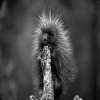

In [8]:
array_to_img(i[0][0])

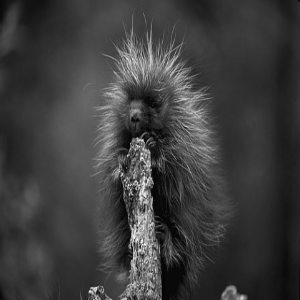

In [9]:
array_to_img(i[1][0])

In [10]:
class DepthToSpace(layers.Layer):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size

    def call(self, input):
        batch, height, width, depth = ops.shape(input)
        depth = depth // (self.block_size**2)

        x = ops.reshape(
            input, [batch, height, width, self.block_size, self.block_size, depth]
        )
        x = ops.transpose(x, [0, 1, 3, 2, 4, 5])
        x = ops.reshape(
            x, [batch, height * self.block_size, width * self.block_size, depth]
        )
        return x


def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(64, 5, **conv_args)(inputs)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor**2), 3, **conv_args)(x)
    outputs = DepthToSpace(upscale_factor)(x)

    return keras.Model(inputs, outputs)

In [11]:
i[0].shape

TensorShape([8, 100, 100, 1])

In [12]:
conv_args = {
    "activation": "relu",
    "kernel_initializer": "orthogonal",
    "padding": "same",
}
layer1 = layers.Conv2D(64, 5, **conv_args)
layer2 = layers.Conv2D(64, 3, **conv_args)
layer3 = layers.Conv2D(32, 3, **conv_args)
layer4 = layers.Conv2D(1 * (upscale_factor**2), 3, **conv_args)

In [13]:
layer1(i[0]).shape

TensorShape([8, 100, 100, 64])

In [14]:
layer2(layer1(i[0])).shape

TensorShape([8, 100, 100, 64])

In [15]:
layer3(layer2(layer1(i[0]))).shape

TensorShape([8, 100, 100, 32])

In [16]:
layer4(layer3(layer2(layer1(i[0])))).shape

TensorShape([8, 100, 100, 9])

In [17]:
batch, height, width, depth = ops.shape(layer4(layer3(layer2(layer1(i[0])))))
batch, height, width, depth

(8, 100, 100, 9)

In [18]:
depth = depth // (upscale_factor**2)
depth

1

In [19]:
x = ops.reshape(
    [layer4(layer3(layer2(layer1(i[0]))))], 
    [batch, height, width, upscale_factor, upscale_factor, 1]
)

In [20]:
x.shape

TensorShape([8, 100, 100, 3, 3, 1])

In [21]:
x = ops.transpose(x, [0, 1, 3, 2, 4, 5])
x.shape

TensorShape([8, 100, 3, 100, 3, 1])

In [22]:
x = ops.reshape(
    x, [batch, height * upscale_factor, width * upscale_factor, 1]
)
x.shape

TensorShape([8, 300, 300, 1])

In [23]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import PIL


def plot_results(img, prefix, title):
    """Plot the result with zoom-in area."""
    img_array = img_to_array(img)
    img_array = img_array.astype("float32") / 255.0

    # Create a new figure with a default 111 subplot.
    fig, ax = plt.subplots()
    im = ax.imshow(img_array[::-1], origin="lower")

    plt.title(title)
    # zoom-factor: 2.0, location: upper-left
    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(img_array[::-1], origin="lower")

    # Specify the limits.
    x1, x2, y1, y2 = 200, 300, 100, 200
    # Apply the x-limits.
    axins.set_xlim(x1, x2)
    # Apply the y-limits.
    axins.set_ylim(y1, y2)

    plt.yticks(visible=False)
    plt.xticks(visible=False)

    # Make the line.
    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
    plt.savefig(str(prefix) + "-" + title + ".png")
    plt.show()


def get_lowres_image(img, upscale_factor):
    """Return low-resolution image to use as model input."""
    return img.resize(
        (img.size[0] // upscale_factor, img.size[1] // upscale_factor),
        PIL.Image.BICUBIC,
    )


def upscale_image(model, img):
    """Predict the result based on input image and restore the image as RGB."""
    ycbcr = img.convert("YCbCr")
    y, cb, cr = ycbcr.split()
    y = img_to_array(y)
    y = y.astype("float32") / 255.0

    input = np.expand_dims(y, axis=0)
    out = model.predict(input)

    out_img_y = out[0]
    out_img_y *= 255.0

    # Restore the image in RGB color space.
    out_img_y = out_img_y.clip(0, 255)
    out_img_y = out_img_y.reshape((np.shape(out_img_y)[0], np.shape(out_img_y)[1]))
    out_img_y = PIL.Image.fromarray(np.uint8(out_img_y), mode="L")
    out_img_cb = cb.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img_cr = cr.resize(out_img_y.size, PIL.Image.BICUBIC)
    out_img = PIL.Image.merge("YCbCr", (out_img_y, out_img_cb, out_img_cr)).convert(
        "RGB"
    )
    return out_img

In [24]:
class ESPCNCallback(keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.test_img = get_lowres_image(load_img(test_img_paths[0]), upscale_factor)

    # Store PSNR value in each epoch.
    def on_epoch_begin(self, epoch, logs=None):
        self.psnr = []

    def on_epoch_end(self, epoch, logs=None):
        print("Mean PSNR for epoch: %.2f" % (np.mean(self.psnr)))
        if epoch % 20 == 0:
            prediction = upscale_image(self.model, self.test_img)
            plot_results(prediction, "epoch-" + str(epoch), "prediction")

    def on_test_batch_end(self, batch, logs=None):
        self.psnr.append(10 * math.log10(1 / logs["loss"]))

In [25]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint.keras"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 1)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, None, None, 64) │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, None, None, 32) │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, None, None, 9)  │         2,601 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depth_to_space (DepthToSpace)   │ (None, None, None, 1)  │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,657 (233.04 KB)

 Trainable params: 59,657 (233.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
Mean PSNR for epoch: 22.42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


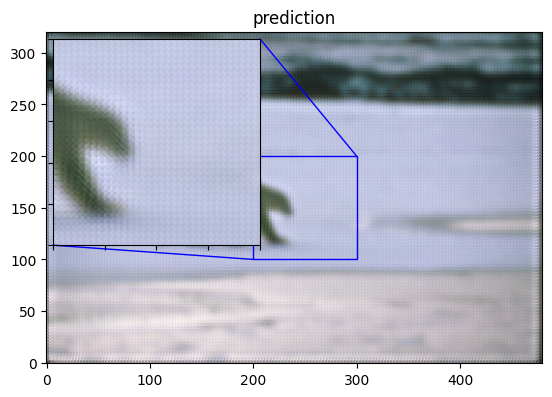

50/50 - 10s - 196ms/step - loss: 0.0338 - val_loss: 0.0059
Epoch 2/100
Mean PSNR for epoch: 24.66
50/50 - 9s - 176ms/step - loss: 0.0046 - val_loss: 0.0033
Epoch 3/100
Mean PSNR for epoch: 25.43
50/50 - 10s - 206ms/step - loss: 0.0033 - val_loss: 0.0027
Epoch 4/100
Mean PSNR for epoch: 25.50
50/50 - 15s - 297ms/step - loss: 0.0030 - val_loss: 0.0030
Epoch 5/100
Mean PSNR for epoch: 26.13
50/50 - 11s - 216ms/step - loss: 0.0029 - val_loss: 0.0025
Epoch 6/100
Mean PSNR for epoch: 26.36
50/50 - 13s - 262ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 7/100
Mean PSNR for epoch: 26.16
50/50 - 10s - 197ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 8/100
Mean PSNR for epoch: 25.98
50/50 - 12s - 234ms/step - loss: 0.0028 - val_loss: 0.0025
Epoch 9/100



KeyboardInterrupt



In [26]:
epochs = 100

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)

In [ ]:
total_bicubic_psnr = 0.0
total_test_psnr = 0.0

for index, test_img_path in enumerate(test_img_paths[50:60]):
    img = load_img(test_img_path)
    lowres_input = get_lowres_image(img, upscale_factor)
    w = lowres_input.size[0] * upscale_factor
    h = lowres_input.size[1] * upscale_factor
    highres_img = img.resize((w, h))
    prediction = upscale_image(model, lowres_input)
    lowres_img = lowres_input.resize((w, h))
    lowres_img_arr = img_to_array(lowres_img)
    highres_img_arr = img_to_array(highres_img)
    predict_img_arr = img_to_array(prediction)
    bicubic_psnr = tf.image.psnr(lowres_img_arr, highres_img_arr, max_val=255)
    test_psnr = tf.image.psnr(predict_img_arr, highres_img_arr, max_val=255)

    total_bicubic_psnr += bicubic_psnr
    total_test_psnr += test_psnr

    print(
        "PSNR of low resolution image and high resolution image is %.4f" % bicubic_psnr
    )
    print("PSNR of predict and high resolution is %.4f" % test_psnr)
    plot_results(lowres_img, index, "lowres")
    plot_results(highres_img, index, "highres")
    plot_results(prediction, index, "prediction")

print("Avg. PSNR of lowres images is %.4f" % (total_bicubic_psnr / 10))
print("Avg. PSNR of reconstructions is %.4f" % (total_test_psnr / 10))

In [ ]:
model.history.model.history.history

### let's update a little bit

In [ ]:
conv_args = {
    "activation": "relu",
    "kernel_initializer": "orthogonal",
    "padding": "same",
}
layer1 = layers.Conv2D(8, 5, **conv_args)
layer2 = layers.Conv2D(16, 5, **conv_args)
layer3 = layers.Conv2D(32, 5, **conv_args)

layer4 = layers.Conv2D(64, 5, **conv_args)
layer5 = layers.Conv2D(64, 3, **conv_args)
layer6 = layers.Conv2D(32, 3, **conv_args)
layer7 = layers.Conv2D(1 * (upscale_factor**2), 3, **conv_args)

In [ ]:
i[0].shape

In [ ]:
l = layer7(
    layer6(
        layer5(
            layer4(
                layer3(
                    layer2(
                        layer1(
                            i[0]
                        )
                    )
                )
            )
        )
    )
)

In [ ]:
l.shape

In [ ]:
class DepthToSpace(layers.Layer):
    def __init__(self, block_size):
        super().__init__()
        self.block_size = block_size

    def call(self, input):
        batch, height, width, depth = ops.shape(input)
        depth = depth // (self.block_size**2)

        x = ops.reshape(
            input, [batch, height, width, self.block_size, self.block_size, depth]
        )
        x = ops.transpose(x, [0, 1, 3, 2, 4, 5])
        x = ops.reshape(
            x, [batch, height * self.block_size, width * self.block_size, depth]
        )
        return x


def get_model(upscale_factor=3, channels=1):
    conv_args = {
        "activation": "relu",
        "kernel_initializer": "orthogonal",
        "padding": "same",
    }
    inputs = keras.Input(shape=(None, None, channels))
    x = layers.Conv2D(8, 5, **conv_args)(inputs)
    x = layers.Conv2D(16, 5, **conv_args)(x)
    x = layers.Conv2D(32, 5, **conv_args)(x)
    
    x = layers.Conv2D(64, 5, **conv_args)(x)
    x = layers.Conv2D(64, 3, **conv_args)(x)
    x = layers.Conv2D(32, 3, **conv_args)(x)
    x = layers.Conv2D(channels * (upscale_factor**2), 3, **conv_args)(x)
    outputs = DepthToSpace(upscale_factor)(x)

    return keras.Model(inputs, outputs)

In [ ]:
early_stopping_callback = keras.callbacks.EarlyStopping(monitor="loss", patience=10)

checkpoint_filepath = "/tmp/checkpoint.keras"

model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor="loss",
    mode="min",
    save_best_only=True,
)

model = get_model(upscale_factor=upscale_factor, channels=1)
model.summary()

callbacks = [ESPCNCallback(), early_stopping_callback, model_checkpoint_callback]
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
epochs = 100

model.compile(
    optimizer=optimizer,
    loss=loss_fn,
)

model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=valid_ds, verbose=2
)

# The model weights (that are considered the best) are loaded into the model.
model.load_weights(checkpoint_filepath)